# Traffic Sign Classification

In [1]:
%matplotlib inline
from IPython.display import display, Markdown

# Disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics

# Traffic sign specific code
import tsdata
import mlutil
import mlvis

print(f"TensorFlow version: {tf.__version__}")
print("GPUs availability: ", tf.config.experimental.list_physical_devices('GPU'))

TensorFlow version: 2.1.0
GPUs availability:  []


## Configuration

In [2]:
task = "part_2"

num_classes = 21

if task == "part_1a":
    # High performance model

    dpconfig = tsdata.DataPipelineConfig(
        target_width  = 32,
        target_height = 32,
        is_color_mode = True,
        augmentation  = "fliplr"
    )

    class_weight = None
    
    model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape = dpconfig.get_keras_input_shape()),
      tf.keras.layers.Dense(128, activation = 'relu'),
      tf.keras.layers.Dense(64,  activation = 'relu'),
      tf.keras.layers.Dense(num_classes)
    ])

    # Larger image classification models - overkill for this problem!

    # base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = dpconfig.get_keras_input_shape()) 
    # x=base_model.output
    # x=tf.keras.layers.GlobalAveragePooling2D()(x)
    # x=tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)
    # model=tf.keras.Model(base_model.input,x)

    # base_model = tf.keras.applications.NASNetMobile(weights = None, include_top = False, input_shape = dpconfig.get_keras_input_shape()) 
    # x=base_model.output
    # x=tf.keras.layers.GlobalAveragePooling2D()(x)
    # x=tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)
    # model=tf.keras.Model(base_model.input,x)

    # model = tf.keras.applications.NASNetMobile(weights = None, include_top = True, input_shape = dpconfig.get_keras_input_shape(), classes = num_classes) 

elif task == "part_1b":
    # Smaller model

    dpconfig = tsdata.DataPipelineConfig(
        target_width  = 16,
        target_height = 16,
        is_color_mode = False,
        augmentation  = "fliplr"
    ) 
    
    class_weight = None

    model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape = dpconfig.get_keras_input_shape()),
      tf.keras.layers.Dense(64, activation = 'relu'),
      tf.keras.layers.Dense(num_classes)
    ])

elif task == "part_2":
    # Extra emphasis on left and right turn signs

    # Using two attempts to improve classification of these two signs:
    #   a) Getting more data, by making use of the fact that these two classes are horizontally mirrored.
    #      The actual augmentation happens in function "load_data_fresh" in "load.py".
    #   b) Increase the class weights for these two classes
        
    dpconfig = tsdata.DataPipelineConfig(
        target_width  = 32,
        target_height = 32,
        is_color_mode = True,
        augmentation  = "turnimprove"  # Make use of symmetries of the 2 classes we want to improve
    )    
        
    # Put stronger emphasis on the classes of interest
    class_weight = dict()
    for class_idx in range(num_classes):
      class_weight[class_idx] = 1.0
    class_weight[12] = 2.0
    class_weight[13] = 2.0
        
    model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape = dpconfig.get_keras_input_shape()),
      tf.keras.layers.Dense(128, activation = 'relu'),
      tf.keras.layers.Dense(64,  activation = 'relu'),
      tf.keras.layers.Dense(num_classes)
    ])

else:
    raise RuntimeError("Invalid task!")

## Load Data

In [3]:
train_images, train_labels = tsdata.load_data(dpconfig, "train")
test_images,  test_labels  = tsdata.load_data(dpconfig, "test")

class_names = tsdata.get_class_names()

num_classes_actual = len(class_names)

if num_classes_actual != num_classes:
    raise RuntimeError("Unexpected number of classes!")

Reading images from 'C:\DevProj\Python\ws\trafficsign_classification\tsdata\train' directory...

Saving to cache file C:\DevProj\Python\ws\trafficsign_classification\tsdata\cache__color_w32_h32_aug-turnimprove__train.npz...
Reading images from 'C:\DevProj\Python\ws\trafficsign_classification\tsdata\test' directory...

Saving to cache file C:\DevProj\Python\ws\trafficsign_classification\tsdata\cache__color_w32_h32_aug-turnimprove__test.npz...


## Explore the data

In [4]:
print(f"train_images.shape = {train_images.shape}")
print(f"len(train_labels)  = {len(train_labels)}")
print(f"test_images.shape  = {test_images.shape}")
print(f"len(test_labels)   = {len(test_labels)}")

train_images.shape = (32571, 32, 32, 3)
len(train_labels)  = 32571
test_images.shape  = (2177, 32, 32, 3)
len(test_labels)   = 2177


### Visually inspect the data

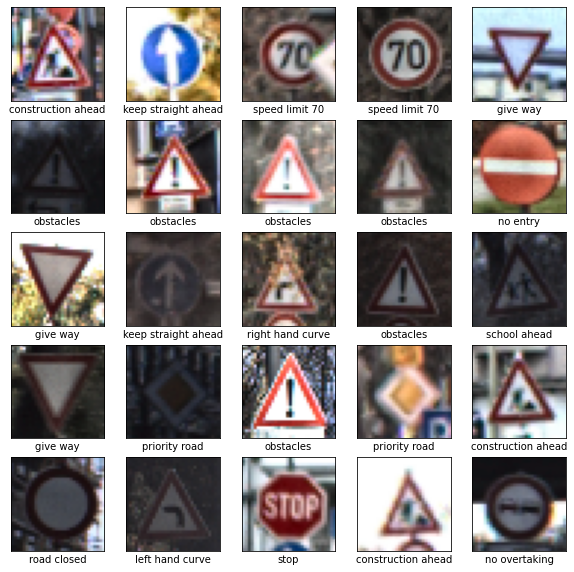

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap = None if dpconfig.is_color_mode else 'gray')
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Train the model

In [6]:
model_family_name = mlutil.generate_model_family_name(dpconfig, friendly_name = task)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback_history     = tf.keras.callbacks.History()
callback_earlystop   = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 20, mode = "min")
callback_checkpoint  = mlutil.get_model_checkpointer(model_family_name)

model.fit(train_images, train_labels, validation_split = 0.2, epochs = 200, class_weight = class_weight,
  callbacks = [callback_history, callback_earlystop, callback_checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 26056 samples, validate on 6515 samples
Epoch 1/200
26056/26056 [==============================] - 4s 159us/sample - loss: 1.0041 - accuracy: 0.7512 - val_loss: 0.4156 - val_accuracy: 0.9024
Epoch 2/200
26056/26056 [==============================] - 3s 123us/sample - loss: 0.3751 - accuracy: 0.9079 - val_loss: 0.2721 - val_accuracy: 0.9306
Epoch 3/200
26056/26056 [==============================] - 3s 121us/sample - loss: 0.2721 - accuracy: 0.9317 - val_loss: 0.2376 - val_accuracy: 0.9391
Epoch 4/200
26056/26056 [==============================] - 3s 117us/sample - loss: 0.2317 - accuracy: 0.9442 - val_loss: 0.2111 - val_accuracy: 0.9521
Epoch 5/200
26056/26056 [==============================] - 3s 129us/sample - loss: 0.2002 - accuracy: 0.9495 - val_loss: 0.2200 - val_accuracy: 0.9446
Epoch 6/200
26056/26056 [==============================] - 3s 129us/sample - loss: 0.1642 - accuracy: 0.9583 - val_loss: 0.2260 - val_accuracy: 0.

26056/26056 [==============================] - 3s 116us/sample - loss: 0.0330 - accuracy: 0.9906 - val_loss: 0.1282 - val_accuracy: 0.9813
Epoch 54/200
26056/26056 [==============================] - 3s 114us/sample - loss: 0.0397 - accuracy: 0.9889 - val_loss: 0.1325 - val_accuracy: 0.9796
Epoch 55/200
26056/26056 [==============================] - 3s 115us/sample - loss: 0.0340 - accuracy: 0.9917 - val_loss: 0.0958 - val_accuracy: 0.9874
Epoch 56/200
26056/26056 [==============================] - 3s 114us/sample - loss: 0.0275 - accuracy: 0.9932 - val_loss: 0.1566 - val_accuracy: 0.9802
Epoch 57/200
26056/26056 [==============================] - 3s 118us/sample - loss: 0.0364 - accuracy: 0.9907 - val_loss: 0.1176 - val_accuracy: 0.9848
Epoch 58/200
26056/26056 [==============================] - 3s 118us/sample - loss: 0.0284 - accuracy: 0.9932 - val_loss: 0.1603 - val_accuracy: 0.9744
Epoch 59/200
26056/26056 [==============================] - 3s 115us/sample - loss: 0.0426 - accuracy

### Model selection: Choose optimum model based on validation loss

In [7]:
val_losses = np.asarray(callback_history.history["val_loss"])
optimum_epoch_num = np.argmin(val_losses) + 1

print(f"Optimum model: epoch = {optimum_epoch_num}, val_loss = {val_losses[optimum_epoch_num - 1]:.3f}")

print(f"Loading optimum model weights (epoch {optimum_epoch_num})...")
mlutil.load_model_epoch(model, model_family_name, optimum_epoch_num)

Optimum model: epoch = 55, val_loss = 0.096
Loading optimum model weights (epoch 55)...


## Evaluate

### Show model summary / computational effort
For these simple models, the number of parameters correlates with the computational effort

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 21)                1365      
Total params: 402,965
Trainable params: 402,965
Non-trainable params: 0
_________________________________________________________________


### Compute model accuracy on test set

In [9]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print(f"\nAccuracy on test set: {test_acc}")

2177/2177 - 0s - loss: 1.4423 - accuracy: 0.9058

Accuracy on test set: 0.9058337211608887


### Make predictions

In [10]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)
labels_predicted = np.argmax(predictions, axis = 1)

### Generate class-wise report

In [11]:
print(sk_metrics.classification_report(test_labels, labels_predicted, target_names=class_names))

                             precision    recall  f1-score   support

             speed limit 20       0.00      0.00      0.00         3
             speed limit 50       0.89      0.67      0.76       108
             speed limit 70       0.83      0.85      0.84       242
              no overtaking       0.95      0.99      0.97        74
                 roundabout       1.00      0.91      0.95        64
              priority road       0.97      0.99      0.98       376
                   give way       0.93      0.97      0.95       228
                       stop       0.95      0.88      0.92        43
                road closed       0.76      0.81      0.78       174
    no heavy goods vehicles       0.69      0.86      0.77        21
                   no entry       1.00      0.93      0.96       432
                  obstacles       0.90      0.97      0.93       126
            left hand curve       0.69      0.95      0.80        21
           right hand curve      

### Compute confusion matrix

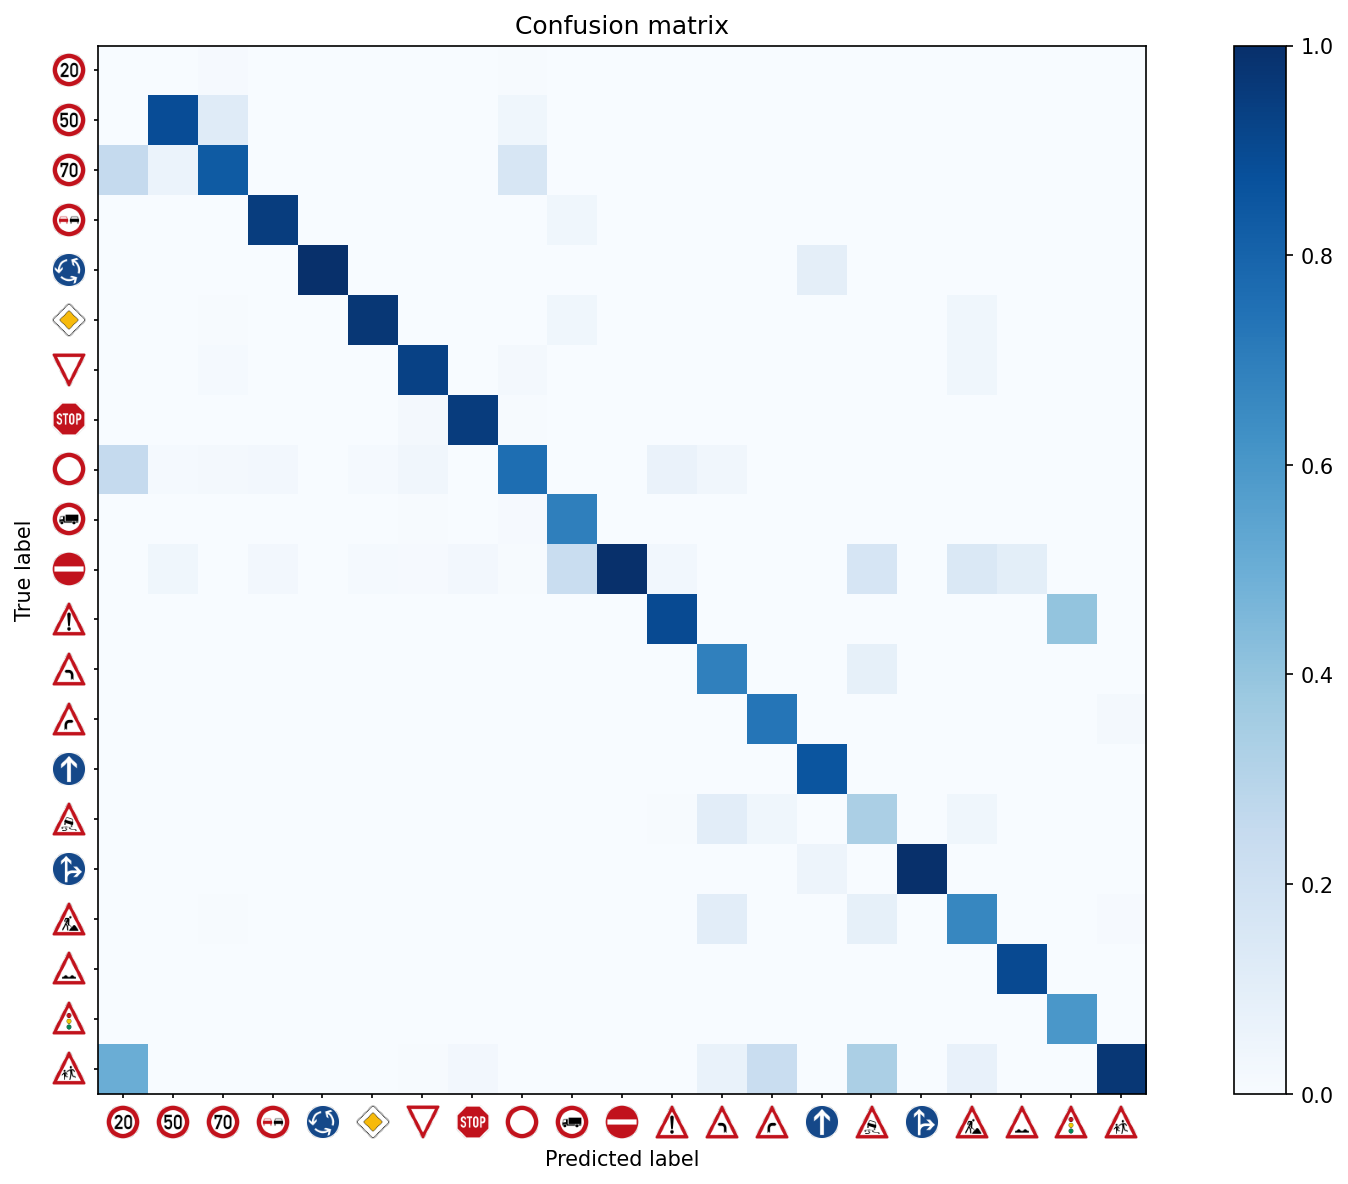

In [12]:
confmat = tf.math.confusion_matrix(test_labels, labels_predicted, num_classes)
mlvis.plot_traffic_sign_confmat(confmat, normalize_by = "cols")

### Verify predictions

Manual inspection of some predictions:

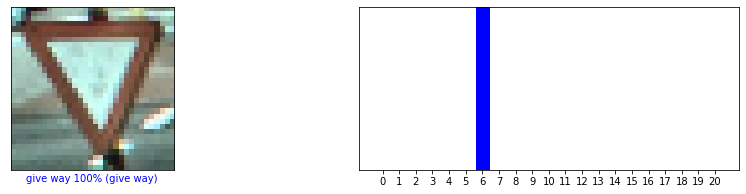

In [13]:
i = 0
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
mlvis.plot_image(class_names, predictions[i], test_labels[i], test_images[i])
plt.subplot(1,2,2)
mlvis.plot_value_array(class_names, predictions[i],  test_labels[i])
plt.show()

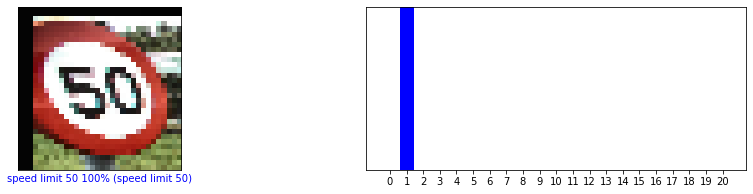

In [14]:
i = 12
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
mlvis.plot_image(class_names, predictions[i], test_labels[i], test_images[i])
plt.subplot(1,2,2)
mlvis.plot_value_array(class_names, predictions[i],  test_labels[i])
plt.show()

Overview of more predictions:

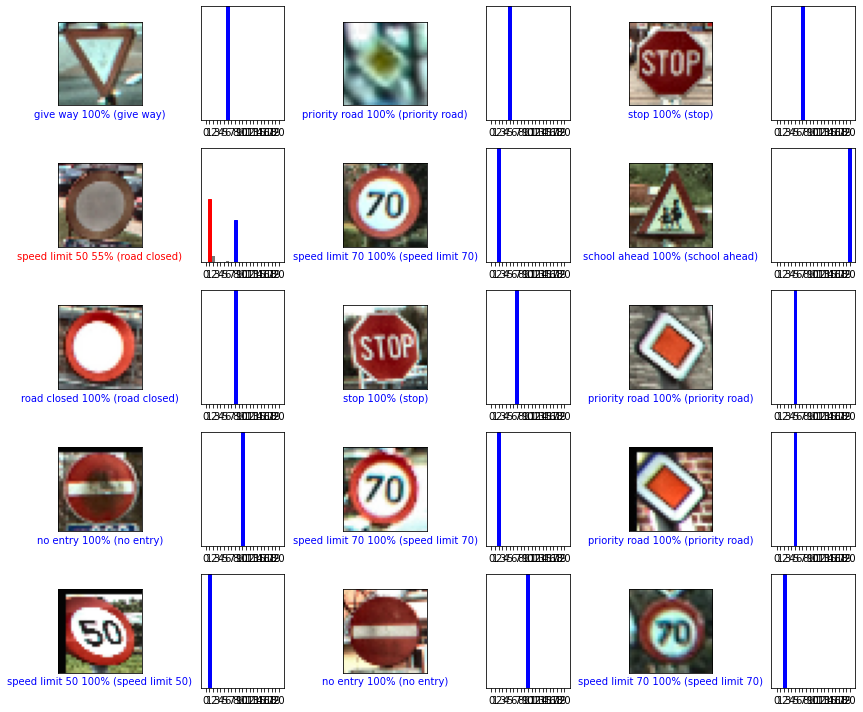

In [15]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  mlvis.plot_image(class_names, predictions[i], test_labels[i], test_images[i])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  mlvis.plot_value_array(class_names, predictions[i], test_labels[i])
plt.tight_layout()
plt.show()

## Further Improvement Ideas

* Use a **larger dataset**, e.g., the full dataset available at: http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset
* Apply more advanced **image enhancement**: gamma correction, histogram stretching, ...
* Do more **augmentation**: perspective transformation, rotation, ...
* Explore more **model architectures**, i.e., try out more advanced models that perform well in image classification tasks
  